# Стратегия взаимодействия с клиентами для сети фитнес-центров

## Исследовательский анализ данных

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
from matplotlib import pyplot as plt
import datetime as dt
import seaborn as sns
import plotly.express as px 
from plotly import graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools

In [2]:
clients = pd.read_csv('/datasets/gym_churn.csv')
clients.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [3]:
clients.duplicated().sum()

0

In [4]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
clients.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Пропуски и дубликаты в данных отсутствуют, все данные приведены к нужным типам.

In [54]:
clients.columns = clients.columns.str.lower()
clients.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Видим, что типичный пользователь живет или работает рядом с фитнес-центром и 50% случаев приобретает абонемент всего на один месяц. Его средний возраст - 29 лет. В среднем он посещает около двух занятий в месяц. В 50% случаев он является нашим клиентом менее трех месяцев, а клиенты, посещающие наш зал более пяти месяцев, встречаются лишь в 25% случаев. 

In [55]:
clients_by_churn = clients.groupby(['churn']).mean()
clients_by_churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


В среднем клиенты, которые не посещали зал больше месяца:
- покупают абонементы на маленький срок;
- реже приходят по акции "приведи друга" и реже являются сотрудниками компаний-партнеров;
- реже ходят на групповые занятия;
- покупают меньше дополнительных услуг;
- являются клиентами всего около месяца;

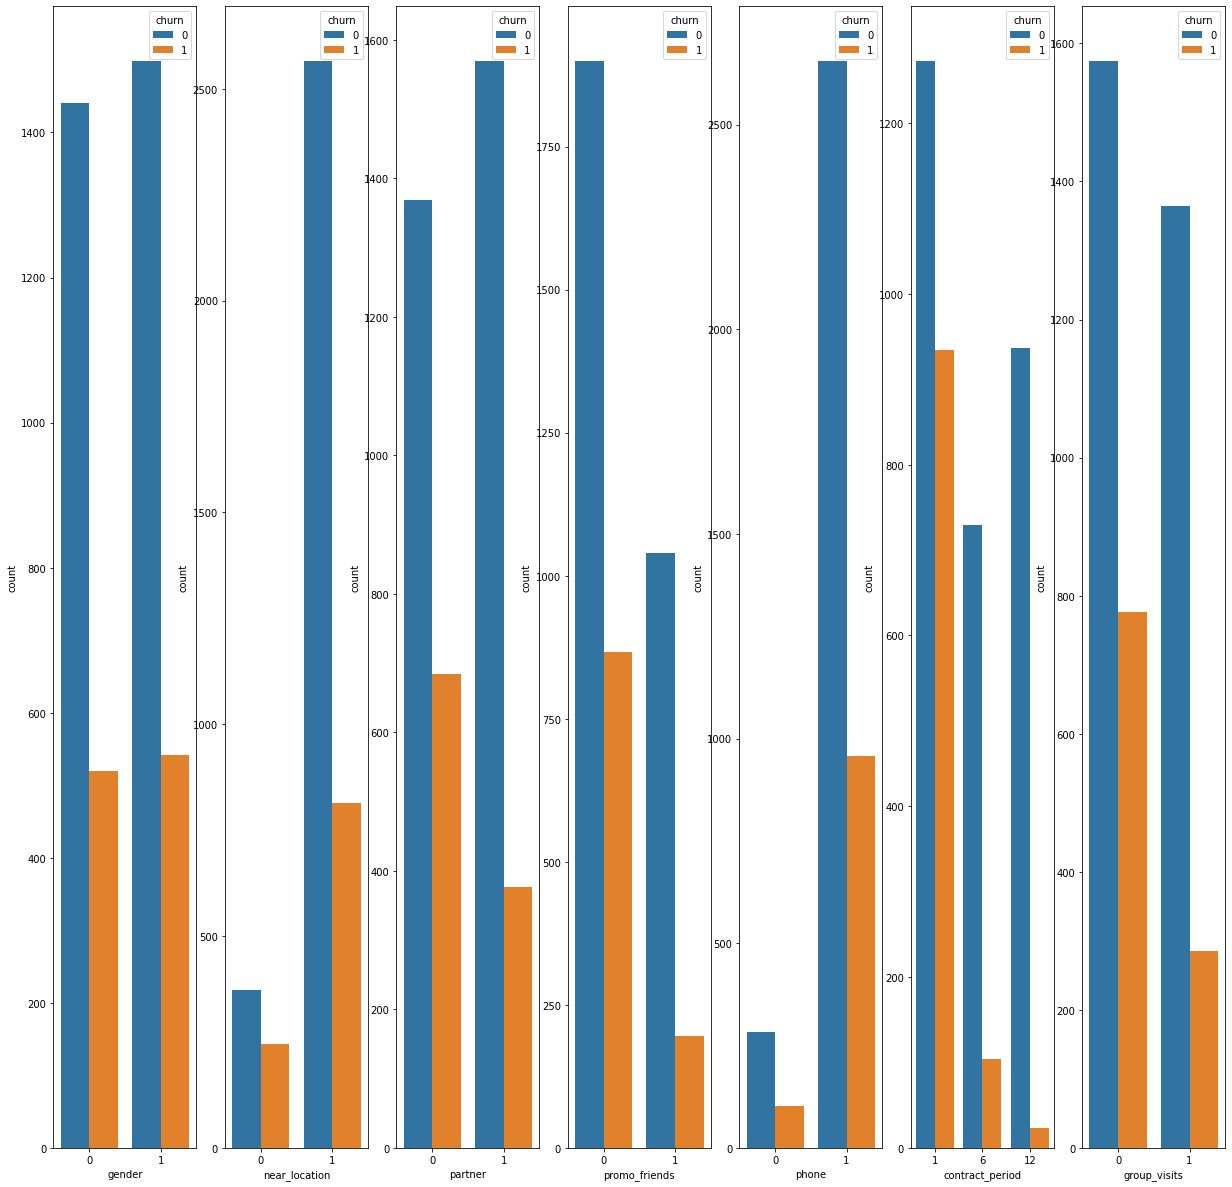

In [7]:
categorical = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']
quantitative = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

fig, axs = plt.subplots(1,7,figsize=(21,21))
axs=axs.flatten()
for i, column in enumerate(categorical):
    sns.countplot(x=column, hue='churn', data=clients, ax=axs[i])

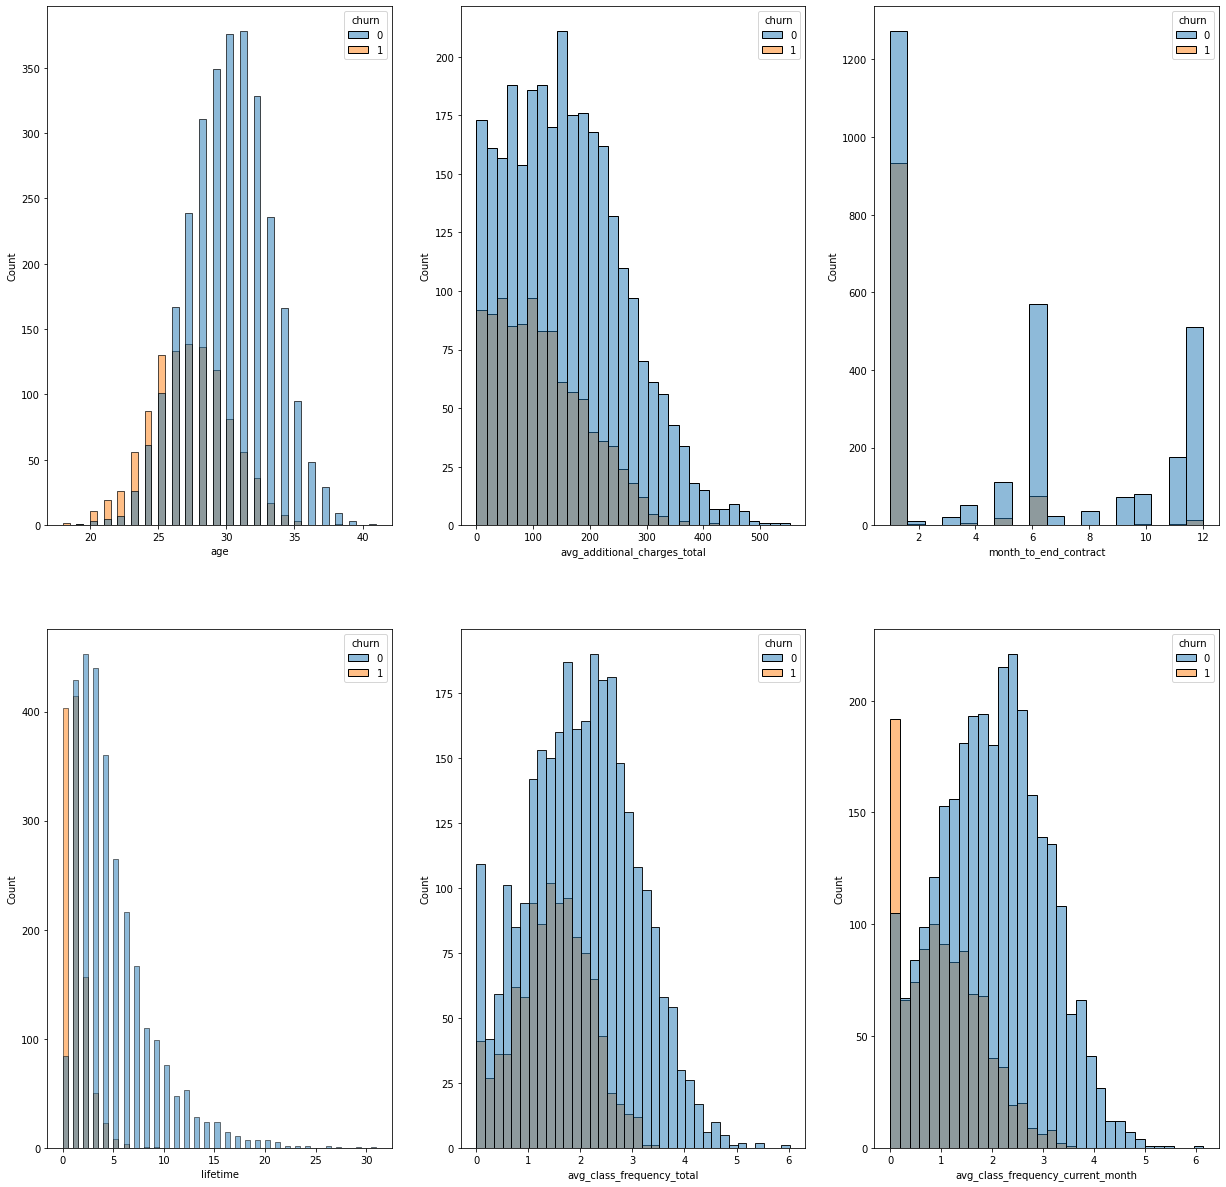

In [8]:
fig, axs = plt.subplots(2, 3,figsize=(21,21))
axs=axs.flatten()
for i, column in enumerate(quantitative):
    sns.histplot(x=column, hue='churn', data=clients, ax=axs[i])

По графикам видим, что:
- значения показателя churn почти одинаковы для обоих полов;
- близость зала к работе или учебе связана с большим количеством сохранившихся клиентов;
- отток клиентов становится меньше относительно количества сохранившихся клиентов в случае, когда речь идет о клиенте, являющмся сотрудиком компании-партнера (сотрудники компаний-партнеров уходят меньше, чем все остальные клиенты);
- акция "приведи друга" также связана с относительно меньшей долей оттока клиентов; 
- чаще всего клиенты указывают свой номер телефона и кажется, что это не сильно влияет на дальнейший отток пользователей;
- чем больше срок действия абонемента, тем меньше доля оттоков. При этом видим, что на графике, изобращающем распределение по количеству месяцев до конца действия абонемента, есть пики на 1, 6 и 12 месяцах - именно на эти сроки выдаются абонементы. Наибольший отток имеет место, когда до конца срока действия абонемента остался один месяц; 
- среди тех, кто посещает групповые занятия, отток меньше, чем среди тех, кто не посещает;
- чаще бросают ходить в спортзал люди более молодого возраста: чем старше, чем меньше доля оттоков. 

In [9]:
churn_corr = clients.corr()
churn_corr

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


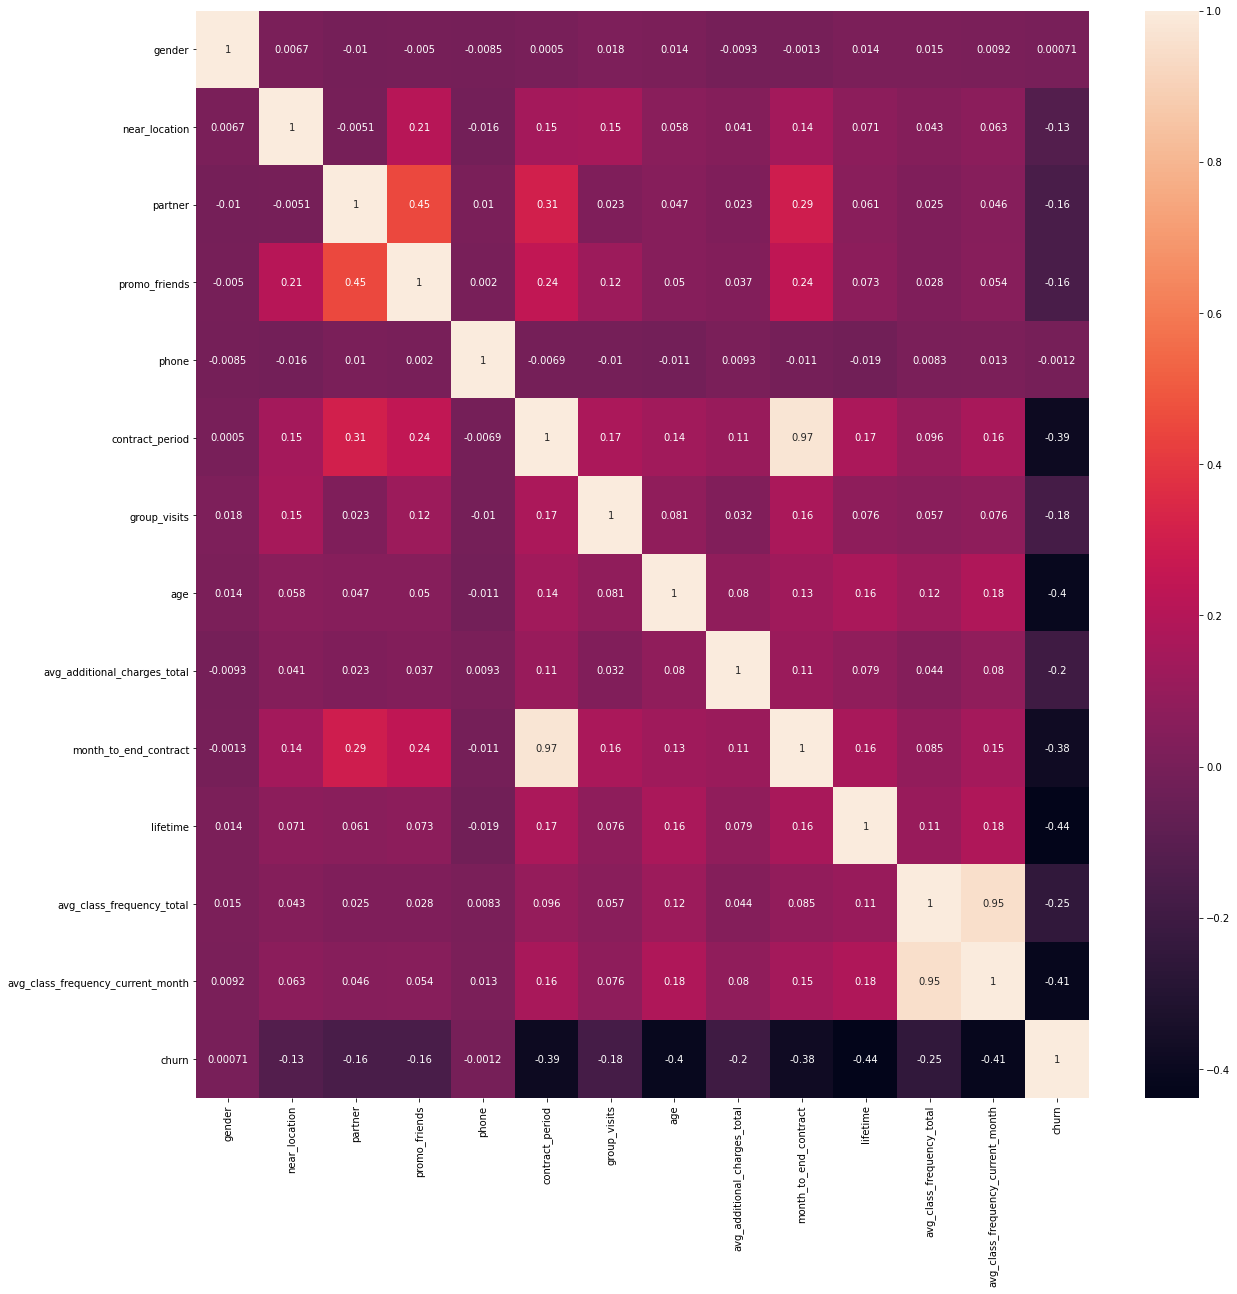

In [10]:
plt.figure(figsize=(20,20))
corr_heatmap = sns.heatmap(data=churn_corr, annot=True)
plt.show()

Матрица корреляций показывает, что наибольшая корреляция оттока наблюдается с такими признаками, как срок абонемента и количество месяцев до его конца, возрастом, лайфтаймом, регулярностью посещения занятий в текущем месяце. Корреляция отрицательная, то есть чем больше значение этих признаков, тем меньше вероятность оттока. Наименее всего отток коррелирует с полом и тем, указал ли клиент номер своего телефона. 

Кроме того, мы видим очень высокую корреляцию между следующими парами признаков:
- contract_period, month_to_end_contract;
- avg_class_frequency_current_month, avg_class_frequency_total

Чтобы избежать мультиколлинеарности, удалим признаки avg_class_frequency_total и month_to_end_contract.

In [56]:
clients = clients.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

## Построение модели прогнозирования оттока клиентов

In [37]:
X = clients.drop(['churn'], axis=1)
y = clients['churn']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [39]:
# задаем алгоритм для модели на основе логистической регресии
model = LogisticRegression(solver='liblinear') 
model.fit(X_train, y_train) # обучаем модель
predictions = model.predict(X_test) # делаем предсказания
probabilities = model.predict_proba(X_test)[:,1]

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
rf_model.fit(X_train, y_train) # обучаем модель
rf_pred = rf_model.predict(X_test) # делаем предсказания

In [40]:
# проверяем модели по метрикам accuracy, precision, recall
def metrics(y_test, y_pred):
    print('Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f}'.format(
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred)))

In [41]:
metrics(y_test, predictions)

Accuracy:0.92 Precision:0.86 Recall:0.82


In [42]:
metrics(y_test, rf_pred)

Accuracy:0.90 Precision:0.84 Recall:0.78


Видим, что значения метрик, полученных в результате применения логистической регрессии ближе к 1, чем значения метрик, полученных в результате применения случайного леса. Следовательно, **логистическая регрессия показала себя лучше**. 

## Кластеризация клиентов

In [43]:
# проводим стандартизацию данных
scaler = StandardScaler()
x_sc = scaler.fit_transform(X)

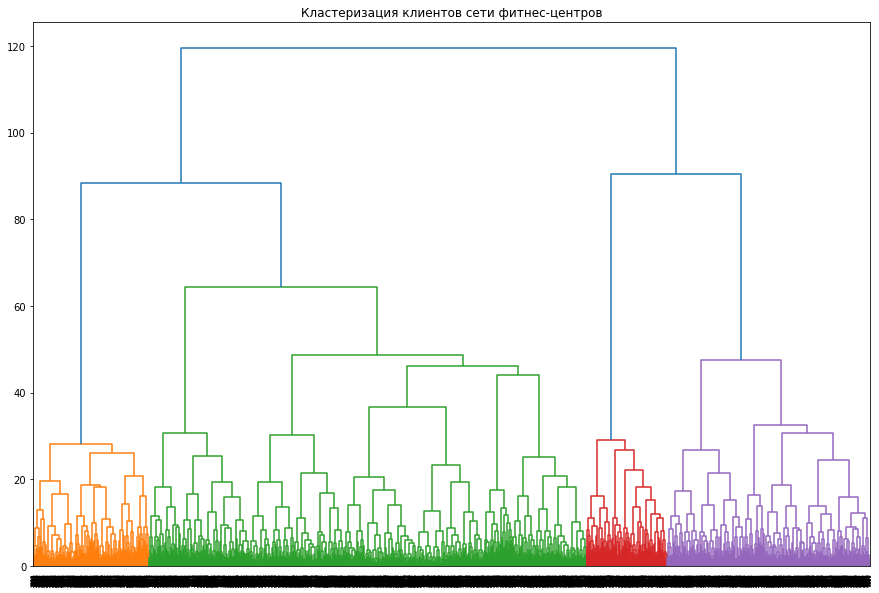

In [44]:
linked = linkage(x_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов сети фитнес-центров')
plt.show() 

In [50]:
# используем алгоритм KMeans для кластеризации со значением кластеров, равным пяти
km = KMeans(n_clusters=5, random_state=0) 
labels = km.fit_predict(x_sc)
clients['clusters'] = labels

In [51]:
clients.groupby(['clusters']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
clusters,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839
1,0.500914,0.000000,0.480804,0.074954,1.0,2.844607,0.224863,28.628885,135.822431,2.956124,1.576963,0.409506
2,0.502033,0.984756,0.781504,0.589431,1.0,10.859756,0.547764,29.972561,161.670998,4.730691,1.973816,0.028455
3,0.573593,0.995671,0.347403,0.243506,1.0,2.589827,0.519481,30.554113,168.358339,5.300866,2.587049,0.034632
4,0.466782,1.000000,0.355479,0.232959,1.0,1.937877,0.295082,27.647110,123.527452,1.905091,1.041837,0.581536


Видим, что кластеры 2 и 3 наименее всего подвержены оттоку. Оба эти кластера отличаются большей среди остальных средней суммой, потраченной на покупку дополнительных услуг, а также средним лайфтаймом, близким к 5. Так как лайфтаймы выражены в месяцах, понимаем, что клиенты наиболее удерживаемых групп в среднем являются клиентами фитнес-центра почти пять месяцев. Для кластера 2 также характерно наличие абонемента на долгий срок, что отличает его от кластера 3, средняя продолжительность абонемента в котором - 2,6 месяцев. 

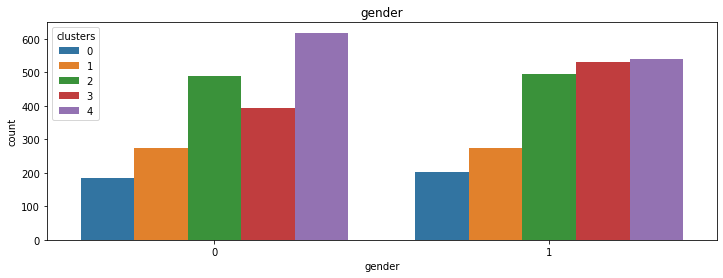

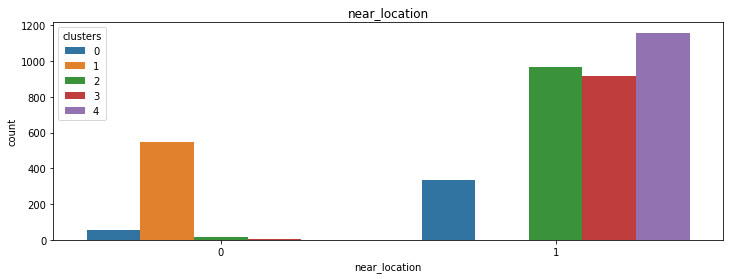

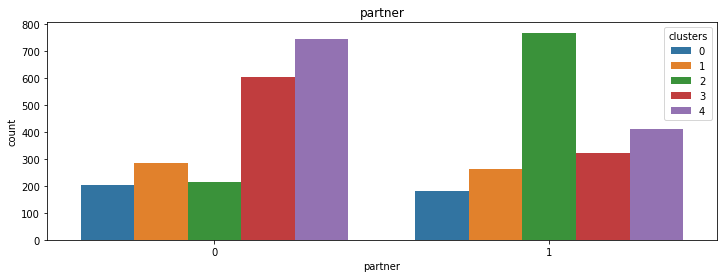

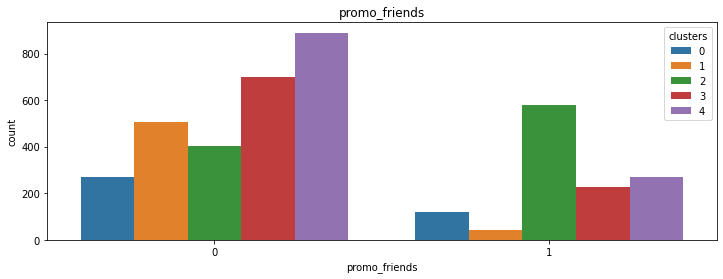

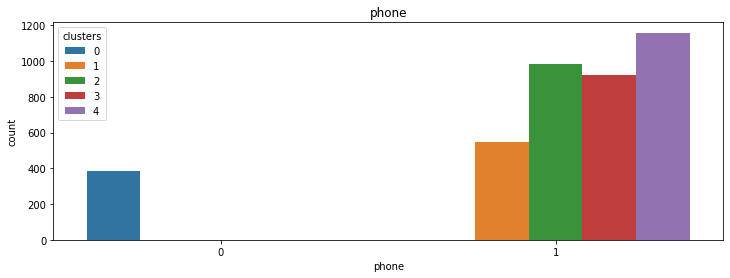

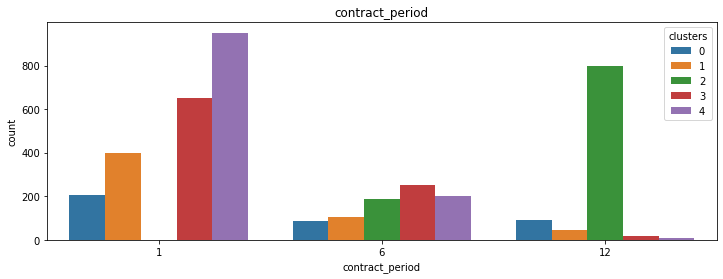

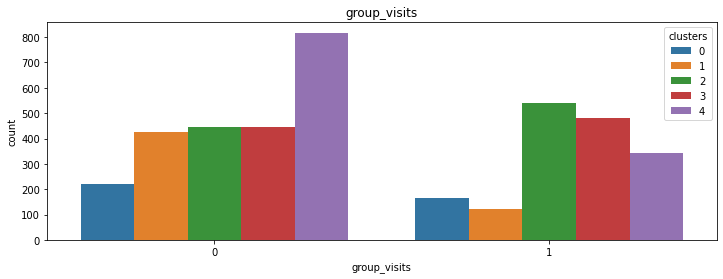

In [47]:
col_pairs = list(itertools.combinations(categorical, 2))
for column in categorical:
    plt.figure(figsize=(12, 4))
    sns.countplot(x=clients[column], hue="clusters", data=clients)
    plt.title(column)
    plt.show()

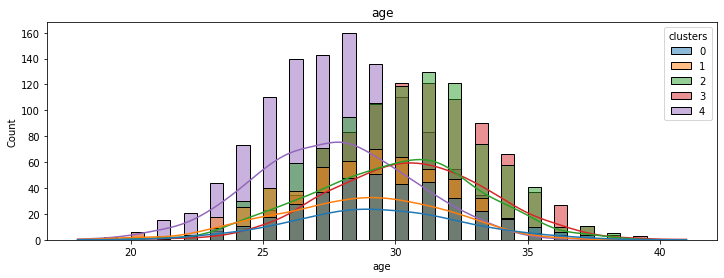

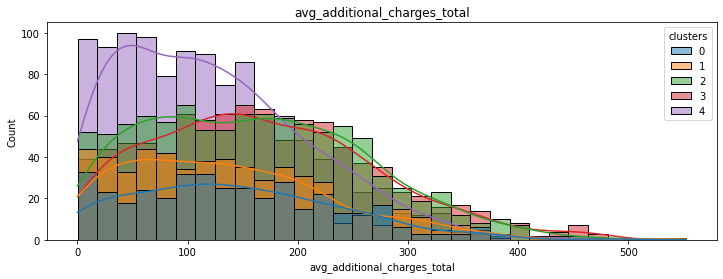

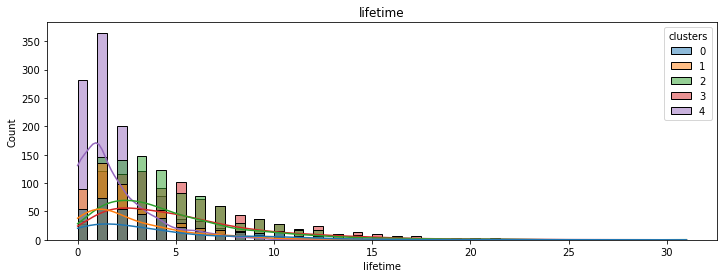

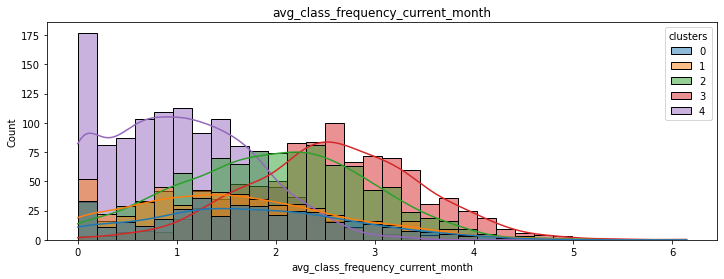

In [48]:
quantitative = ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_current_month']

col_pairs = list(itertools.combinations(quantitative, 2))
for column in quantitative:
    plt.figure(figsize=(12, 4))
    sns.histplot(x=clients[column], hue="clusters", data=clients, kde=True, palette="tab10")
    plt.title(column)
    plt.show()

In [49]:
clusters_list = [0, 1, 2, 3, 4]

for i in clusters_list:
    print('Доля оттока в кластере', i, 'равна', round(((len(clients.query('clusters == @i and churn == 1'))/len(clients.query('clusters == @i')))*100),1), '%')

Доля оттока в кластере 0 равна 26.7 %
Доля оттока в кластере 1 равна 41.0 %
Доля оттока в кластере 2 равна 2.8 %
Доля оттока в кластере 3 равна 3.5 %
Доля оттока в кластере 4 равна 58.2 %


Действительно, видим, что наименьшая доля оттока в кластерах 2 и 3, а наибольшая - в кластере 4. Особенности третьего кластера - самый короткий лайфтайм и малое количество посещаемых занятий, а также короткий срок действия абонемента, при этом клиенты этой когорты живут или работают вблизи фитнес-центра. Кажется, что это те клиенты, которые решили внедрить в свою жизнь полезную привычку и приобрели на пробу самый маленький абонемент в фитнес-центре с удобным расположением. 

## Выводы и рекомендации

Мы провели исследовательский анализ данных и выяснили, что наибольшая линейная корреляция оттока наблюдается с такими признаками, как срок абонемента и количество месяцев до его конца, возраст, лайфтайм и регулярность посещения занятий в текущем месяце. Корреляция отрицательная, то есть чем больше значение этих признаков, тем меньше вероятность оттока. Наименее всего отток коррелирует с полом и тем, указал ли клиент номер своего телефона. 

Для прогнозирования оттока клиентов мы рекомендуем использовать алгоритм логистической регрессии, который показал лучшие результаты в сравнении со случайным лесом. Также мы выделили пять кластеров клиентов. 

**Рекомендации:**

1. Сейчас лучше всего удерживаются клиенты, которые являются клиентами сети в среднем более 4 месяцев, однако удержание больше (кластер 2), если клиенты покупают абонемент на долгий срок. Кажется, можно увеличить удержание постоянных клиентов, если предлагать им скидки на абонементы с долгим сроком действия, "переводя" их, таким образом, из 3 кластера в 2. 

2. Хуже всего удерживаются клиенты-новички, которые, купив абонемент, почти сразу перестают посещать фитнес-центр (кластер 4) - так отваливается 51,4% клиентов кластера. Возможно, можно уменьшить этот отток, предложив новичкам программы "онбординга", рассчитанные на новичков в фитнесе, которые помогали бы им привыкнуть к тренировкам и полюбить их. 

3. Отток в кластере 1, кажется, свящан с неудобным для клиентов расположением фитнес-центра, который они выбрали: занятия они посещают редко, а значение столбца near_location - 0. Возможно, этим клиентам может подойти другой фитнес-центр сети? Если предложить им единый абонемент на все филиалы и порекомендовать более удобный, возможно, удастся снизить отток. 